<a href="https://colab.research.google.com/github/capieroni/SCOPE/blob/OpenCV_train/SCOPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scientific Chart and Output Parsing Engine (SCOPE)

**The Scientific Chart and Output Parsing Engine** (SCOPE) Project is the
development and refinement of a system for recognizing and extracting charts and
graphs from scientific publications.

The overarching goal of this project is to build the foundation for a larger-scale program (REALM) that will be able to extract data from all figures within a scientific publication, with an emphasis on identifying “negative” or insignificant data.

Project objectives include accurately detecting and isolating charts and graphs, then converting these images into structured data for any future analysis. The project will also present accuracy metrics for each model iteration and refinement, emphasizing the specific improvements that I was able to achieve in performance optimization.

## Initial Setup

Mount Google Drive

In [53]:
#if not already mounted:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing libraries

In [54]:
!pip install pdfplumber #parses pdf content
!pip install transformers #LayoutLMv2

!sudo apt install tesseract-ocr #pytesseract for OCR
!pip install pytesseract

!pip install torch==1.12 torchvision torchaudio #PyTorch version compatible with detectron2

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html #detectron2

!pip install pdf2image #handles pdf images

!pip install torch torchvision torchaudio #object detection model

!pip install opencv-python-headless #image processing

!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [55]:
from PIL import Image #python imaging library (to open, manipulate, and display images)
from pathlib import Path #just simplifies file management for me
import shutil #lets me copy the images over to my google drive folder
import pdfplumber
import os
import cv2
from matplotlib import pyplot as plt
import pdf2image

Grab pdfs from folder

In [56]:
path = '/content/drive/MyDrive/SCOPE/scientific_pdfs'

#listing all PDF files
files = [f for f in os.listdir(path) if f.endswith('.pdf')]
print("PDF files:", files)

#if all works, the list should include all 13 files

PDF files: ['11386378.pdf', 'biochemj00515-0110.pdf', '19161491.pdf', '12381735.pdf', 'biochemj00498-0024.pdf', '20006622.pdf', '26525112.pdf', '20601430.pdf', '27965450.pdf', '31710151.pdf', 'nature11524.pdf', '12775706.pdf', '20595258.pdf']


## Step 2: Testing Program on one file

First, we'll start testing with one pdf that seems to have an easier layout to analyze:

20601430.pdf (A Glucose Transporter Can Mediate Ribose Uptake)

In [57]:
pdf_path = '/content/drive/MyDrive/SCOPE/scientific_pdfs/20601430.pdf'

### False Strategy (1): LayoutLMv2

Using pdfplumber to load the pages in iteration

In [58]:
# pdf = pdfplumber.open(path)
# pages = [page for page in pdf.pages]

Then, we'll use LayoutLMv2 for layout extraction from the pages using a pre-trained model

First, I got an error saying I needed to import the detectron2 library so I added it to the imports.

In [59]:
# from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification
# from PIL import Image

# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
# model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased")


After messing around for a little while, it turns out that LayoutLMv2 will not be able to be utilized as detectron2 is not compatible with the google colab environment. So instead, we will be turning to a different aproach

### False Strategy (2): YOLOv5

pdf2image for PDF page conversion and object detection using a lighter model, such as YOLOv5 or OpenCV-based detection, to locate charts in images.

Installing pdf2image for pdf page conversion and two different object detection models:

- PyTorch (for YOLOv5)
- OpenCV-based detection

In [60]:
# !pip install pdf2image #handles pdf images

# !pip install torch torchvision torchaudio #object detection model

# !pip install opencv-python-headless #image processing

Then we'll install YOLOv5 from Github

The pro of this model is that it is a flexible, fast object detection model

In [61]:
# !git clone https://github.com/ultralytics/yolov5  #clone the repository
# %cd yolov5
# !pip install -r requirements.txt  # install dependencies

After running into an error we need to install Poppler to enable pdf2image to read and convert PDF files to images.

In [62]:
# !apt-get install -y poppler-utils

Specifying the pdf images folder:

In [63]:
# output_folder = "/content/drive/MyDrive/REALM/20601430_outputs"

Now we'll use pdf2image to convert PDF pages into images and YOLOv5 to detect and extract charts from these images

In [64]:
# output_folder = "/content/drive/MyDrive/REALM/20601430_outputs"
# os.makedirs(output_folder, exist_ok=True)

# #convert pdf to image
# images = pdf2image.convert_from_path(pdf_path, dpi=300)
# for i, image in enumerate(images):
#     image_path = f"{output_folder}/20601430_page_{i+1}.png"
#     image.save(image_path, "PNG")

Now we'll run YOLOv5 for Object Detection

As a quick explaination, YOLOv5 will detect possible chart regions. It comes pre-trained but it may be need to be fine-tuned with some annotated samples of chart images

In [65]:
# #loading the yolov5 model
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

There are also other models we can try out if this accuracy is not that good.

In [66]:
# #creating a folder to store images with chart/graph detections
# output_detected_folder = "/content/drive/MyDrive/REALM/20601430_yolo_detections"
# os.makedirs(output_detected_folder, exist_ok=True)

In [67]:
# #running object detection on each page (looping)
# for image_path in Path(output_folder).glob("*.png"):
#     results = model(image_path)  #this runs the detection

#     #check if there were any detections actually made
#     if results.pred[0].shape[0] > 0:  #if num of shapes is more than 0 (aka shape detected)
#         results.save()  #save the annotated image

#         #display the image (just so we can see if its detection was accurate)
#         display(Image.open(image_path))

#         #copy images over to our folder in google drive
#         detected_image_path = Path(output_detected_folder) / image_path.name
#         shutil.copy(image_path, detected_image_path)
#         print(f"Saved detected image to {detected_image_path}")
#     else:
#         print(f"No charts detected in {image_path}, skipping.")


Based on manually inspecting the images and whether they have figures or not- YOLOv5 only correctly detected on image with charts/graphs on it.

Page 3, Page 4 (detected), Page 5, and Page 6 should be the images with detected charts/graphs. It also incorrectly detected that Page 10 had a graph.

Thus, here is the breakdown:
True Positive: 1 (Page 4)
False Positive: 1 (Page 10)
False Negative: 3 (Page 3, 5, 6)
True Negative: 5 (Page 1, 2, 7, 8, 9)

Accuracy is defined as:

(TP + TN) / (TP + FP + FN + TN) =
(1 + 5) / (1 + 1 + 3 + 5) = 0.6 = 60%

Thus, our accuracy with this model is 60%.

So now we need to think about our future possibilities:
- Try another pre-trained model
- Fine-tune this model to be more accurate
- Train my own model

### Strategy 3: OpenCV

Let's try OpenCV

This code pulls the whole pages with bounding boxes over the graphs/charts

Making sure pdfs are converted to images

In [68]:
output_folder = "/content/drive/MyDrive/SCOPE/20601430_outputs"
os.makedirs(output_folder, exist_ok=True)

#convert pdf to image
images = pdf2image.convert_from_path(pdf_path, dpi=300)
for i, image in enumerate(images):
    image_path = f"{output_folder}/20601430_page_{i+1}.png"
    image.save(image_path, "PNG")

Making sure folders needed to store images are created and they exist

In [69]:
output_folder = "/content/drive/MyDrive/SCOPE/20601430_outputs"

detected_charts_folder = "/content/drive/MyDrive/SCOPE/20601430_opencv_detections"
cropped_charts_folder = "/content/drive/MyDrive/SCOPE/20601430_opencv_cropped"

In [70]:
# for image_path in Path(output_folder).glob("*.png"):
#     #read image in grayscale
#     image = cv2.imread(str(image_path))
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     #adaptive thresholding (highlights chart areas)
#     thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                    cv2.THRESH_BINARY_INV, 11, 2)

#     #canny edge detection
#     edges = cv2.Canny(thresh, 100, 200)

#     #find contours
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     #track if detections are made
#     detections_made = False
#     detected_region_counter = 0  #for cropped image naming

#     #iteration through contours and filtering based on area and aspect ratio
#     for contour in contours:
#         min_area = 1000  #min area threshold for chart
#         if cv2.contourArea(contour) > min_area:
#             x, y, w, h = cv2.boundingRect(contour)

#             #filter based on aspect ratio (if needed)
#             aspect_ratio = w / float(h)
#             if 0.5 < aspect_ratio < 2.0:  #adjust aspect ratio range
#                 #mark if there was a detection
#                 detections_made = True

#                 #drawing bounding box on image
#                 cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

#                 #crop detected chart
#                 cropped_region = image[y:y+h, x:x+w]
#                 cropped_image_path = Path(cropped_charts_folder) / f"{image_path.stem}_chart_{detected_region_counter}.png"
#                 cv2.imwrite(str(cropped_image_path), cropped_region)
#                 detected_region_counter += 1

#     #save and display (only there was a detection)
#     if detections_made:
#         #save annotated image to folder
#         annotated_image_path = Path(detected_charts_folder) / f"annotated_{image_path.name}"
#         cv2.imwrite(str(annotated_image_path), image)

#         #display annotated image
#         plt.figure(figsize=(8, 8))
#         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #converting to RGB for matplotlib display
#         plt.title(f"Detected charts in {image_path.name}")
#         plt.axis("off")
#         plt.show()
#     else:
#         print(f"No charts detected in {image_path.name}, skipping.")


I ran this code 3 times and it was consistent all 3 times

From this initial run of OpenCV we can see that it detects 35 charts/graphs from this scientific publication.

To calculate this accuracy we will use a similar method than before, except manually count the number of charts that actually exist

*   Page 3 has 3 graphs
*   Page 4 has 2 (readable) charts
*   Page 5 has 4 (readable) charts
*   Page 6 has 2 charts

Thus a total of 11 charts and graphs in this particular pdf (20601430.pdf)

Our model detected 35 of these charts, but let's calculate a very simple accuracy of these detections:

8 (true detections) / 11 (total) = 72.7% accuracy

This is definitely an accuracy we can work with, the issue is to fine tune the model to

a. recognize graphs as well and

b. stop detecting letters as figures


Also, here a function to clear my folder for each run:

In [71]:
def clear_folder(folder_path):
    shutil.rmtree(folder_path, ignore_errors=True)
    os.makedirs(folder_path, exist_ok=True)

In [72]:
clear_folder(detected_charts_folder)
clear_folder(cropped_charts_folder)

To graph and tackle (b), I've raised the min area threshold to 3000 and then added a circularity check to attempt to sort out those small o's and 0's that the model is recognizing as charts

In [73]:
# for img_path in Path(output_folder).glob("*.png"):
#     #read image in grayscale (same)
#     img = cv2.imread(str(img_path))
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     #adaptive thresholding (highlights chart areas)
#     thresh_img = cv2.adaptiveThreshold(
#         gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
#     )

#     #canny edge detection (same)
#     edge_img = cv2.Canny(thresh_img, 100, 200)

#     #find contours
#     cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     #track if detections are made
#     found_chart = False
#     chart_count = 0

#     #iteration through contours and filtering based on area and aspect ratio
#     for c in cnts:
#         min_area = 3000  #increased min area threshold
#         if cv2.contourArea(c) > min_area:
#             x, y, w, h = cv2.boundingRect(c)

#             #filter based on aspect ratio (if needed)
#             ratio = w / float(h)
#             if 0.5 < ratio < 2.5:

#                 #checking for circle images
#                 perimeter = cv2.arcLength(c, True)
#                 area = cv2.contourArea(c)
#                 circularity = 4 * 3.14159 * (area / (perimeter * perimeter)) if perimeter != 0 else 0
#                 if circularity > 0.6:  #circular shapes have a higher circularity
#                     continue  #skip this contour if it is likely circular

#                 found_chart = True  #mark detection made

#                 #drawing bounding box on image
#                 cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

#                 #crop detected chart
#                 cropped_img = img[y:y+h, x:x+w]
#                 crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
#                 cv2.imwrite(str(crop_path), cropped_img)
#                 chart_count += 1

#     #save and display (only there was a detection)
#     if found_chart:
#         anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
#         cv2.imwrite(str(anno_path), img)

#         #display annotated image
#         plt.figure(figsize=(8, 8))
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(f"Detected charts in {img_path.name}")
#         plt.axis("off")
#         plt.show()
#     else:
#         print(f"No charts detected in {img_path.name}, skipping.")


Now the model is not able to recognize ANY charts/graphs. FAIL

In [74]:
# for img_path in Path(output_folder).glob("*.png"):
#     #read image in grayscale (same)
#     img = cv2.imread(str(img_path))
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     #adaptive thresholding (highlights chart areas)
#     thresh_img = cv2.adaptiveThreshold(
#         gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
#     )

#     #canny edge detection (same)
#     edge_img = cv2.Canny(thresh_img, 100, 200)

#     #find contours
#     cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     #track if detections are made
#     detected_areas = []
#     found_chart = False
#     chart_count = 0

#     #iteration through contours and filtering based on area and aspect ratio
#     for c in cnts:
#         area = cv2.contourArea(c)
#         min_area = 1000  #min area threshold

#         if area > min_area:
#             x, y, w, h = cv2.boundingRect(c)
#             aspect_ratio = w / float(h)

#             #filter based on aspect ratio
#             if 0.5 < aspect_ratio < 2.0:
#                 #save bounding box and area
#                 detected_areas.append((area, x, y, w, h))

#     #calculate average area to filter through
#     if detected_areas:
#         avg_area = sum([a[0] for a in detected_areas]) / len(detected_areas)
#         refined_min_area = avg_area * 0.3  #set minimum area to 30% of average

#         #filter contours by refined area and draw bounding boxes
#         for area, x, y, w, h in detected_areas:
#             if area >= refined_min_area:
#                 found_chart = True  #confirm chart detection

#                 #drawing bounding box on image
#                 cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

#                 #crop detected chart
#                 cropped_img = img[y:y+h, x:x+w]
#                 crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
#                 cv2.imwrite(str(crop_path), cropped_img)
#                 chart_count += 1

#     #save and display (only there was a detection)
#     if found_chart:
#         anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
#         cv2.imwrite(str(anno_path), img)

#         #display annotated image
#         plt.figure(figsize=(8, 8))
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(f"Detected charts in {img_path.name}")
#         plt.axis("off")
#         plt.show()
#     else:
#         print(f"No charts detected in {img_path.name}, skipping.")


Accuracy goes up when we refine it this way. It is NOT filtering out noise though still. I'm thinking about using image size or file size as a method to filter out noise as it is practically impossible for a figure to be that small.

I'm going to work on a new strategy to be able to extract the data:

**Increase Min Area Threshold**: I'm going to set it to 2000 to help eliminate those very small objects like letters

**Circularity**: I'll filter out circular objects (like o's and 0's)

**Width-Height Ratio**: charts are usually rectangular or non-square so I'll try filtering out square-like objects

**Density**: I'll measure contour density to help elimiate thin or scattered objects

**Contour Shape Check (Hull vs. Area)**: comparing countour area and its convex hull area might help detect shape irregularity (like letters)

No charts detected in 20601430_page_9.png, skipping.
No charts detected in 20601430_page_2.png, skipping.
No charts detected in 20601430_page_3.png, skipping.
No charts detected in 20601430_page_1.png, skipping.


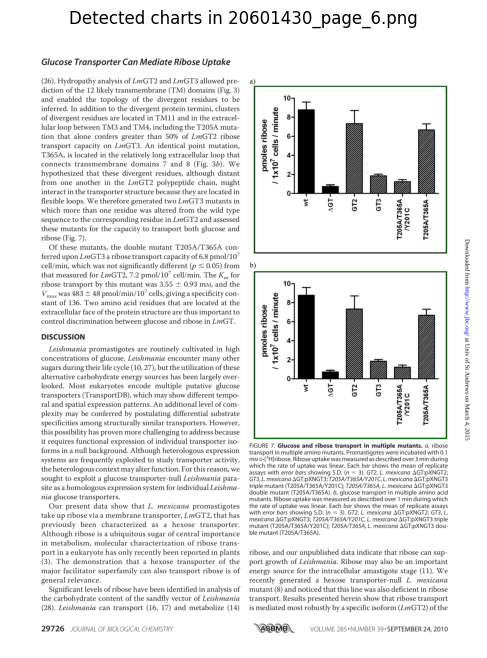

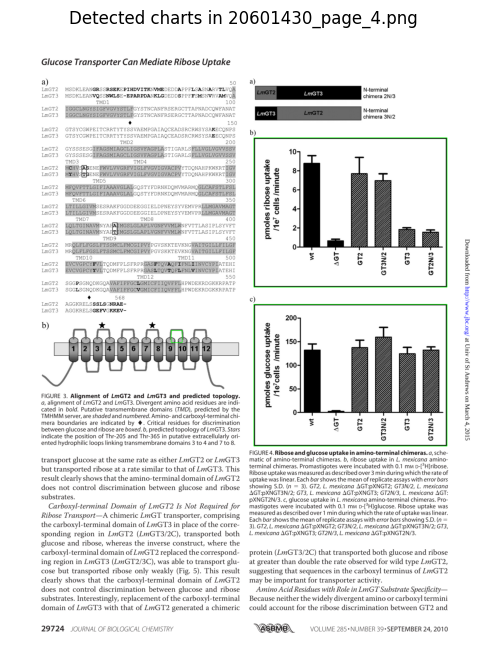

No charts detected in 20601430_page_8.png, skipping.
No charts detected in 20601430_page_7.png, skipping.


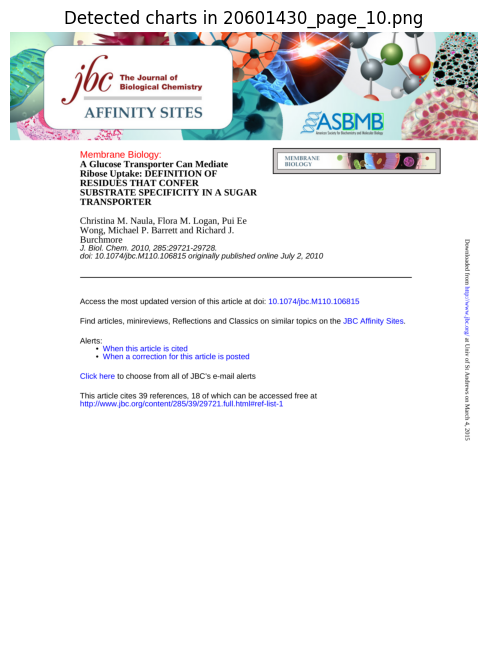

In [75]:
for img_path in Path(output_folder).glob("*.png"):
    #reads image file and loads it into OpenCV compatible format (multidimentional array)
    img = cv2.imread(str(img_path))
    #converts color image to grayscale (reducing to one intensity channel (brightness))
    #this simplifies processing
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #converts grayscale image to binary (black&white) based on calculated threshold
    #gray_img: image
    #255: max val assigned to pixels (that meet threshold condition)
    #cv2.ADAPTIVE_THRESH_GAUSSIAN_C: sets the method to gaussian, each pixel threshold
    #is computed based on nearby pixels
    #cv2.THRESH_BINARY_INV: inverts binary image, setting pizels to below
    #threshold 255 (white) and above 0 (black)
    # 11 + 2: 11 is the block size or area of neighboring pixels
    # 2 is a constant subtracted from mean to fine-tune the threshold
    thresh_img = cv2.adaptiveThreshold(
        gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    #canny edge detection
    #cv2.Canny: detects edges in binary image using canny algorithm
    #100 + 200: the lower and upper thresholds for edge detection
    #pixels with gradients about 200 are edges and below 100 is ignored
    edge_img = cv2.Canny(thresh_img, 100, 200)

    #finding contours
    #cv2.findContours: finds contours (outlines of shapes) in image
    #cv2.RETR_EXTERNAL: retrieves only outer contours (we ignored nested)
    #cv2.CHAIN_APPROX_SIMPLE: simplifies the contours to reduce points and storage
    #cnts: stores list of detected contours as array of points
    cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #track detections and initialize counter for the cropped images
    found_chart = False
    chart_count = 0

    #filter contours (using our five techniques)
    #loops over each detected contour in cnts
    #cv2.contourArea(c): calculates the area of contour c.
    #cv2.arcLength(c, True): calculates perimeter of contour c (True = contour is closed)
    for c in cnts:
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)

        #1: min area threshold (might can adjust based on image size)
        if area < 2000:
            continue

        #bounding boxes
        #cv2.boundingRect(c): creates bounding rect. for contour c
        #returns the top-left corner coordinates (x,y) and width and height
        #(for further checks)
        x, y, w, h = cv2.boundingRect(c)

        #2: aspect ratio check (non-rectangular objects)
        #filters out contours that are too narrow or tall
        aspect_ratio = w / float(h)
        if not (0.5 < aspect_ratio < 2.5):  #can be adjust based on chart dimensions
            continue

        #3: circularity check (filter circular/small shapes)
        #circularity: 4 * (pi) * area/(perimeter^2)
        #circularity close to 1 is circular
        circularity = 4 * 3.14159 * (area / (perimeter * perimeter)) if perimeter != 0 else 0
        if circularity > 0.8:
            continue

        #4: density (filter thin or sparse contours)
        #density: area / (w * h) where lower density is thin or sparse
        density = area / (w * h)
        if density < 0.4:
            continue

        #5: shape (convex hull comparison)
        #cv2.convexHull(c): calculates convex hull of contour c,
        #this is the smaller convex shape that encloses it
        #solidity: area / hull_area where lower values are irregular
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area != 0 else 0
        if solidity < 0.7:
            continue

        #if all checks are passed
        found_chart = True

        #cv2.rectangle() draws a green rect around chart area
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        #crop region and save
        #extracts chart region using bounding box coords (x,y,w,h)
        cropped_img = img[y:y+h, x:x+w]
        crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
        cv2.imwrite(str(crop_path), cropped_img)
        chart_count += 1

    #save and display (just to visualize without going into folder)
    if found_chart:
        anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
        cv2.imwrite(str(anno_path), img)

        #display
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected charts in {img_path.name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No charts detected in {img_path.name}, skipping.")


The accuracy of this new model is 8/11 or about 73% with 3 false detections.


New challenges:
- Still does not detect graphs (might can get code)
- Some letters are still detected (specifically B's)
- Due to filter out circles and squares, charts from other pdfs may not work well with this refined model

Now, let's tackle the graph recognition.

In [76]:
# import cv2
# from matplotlib import pyplot as plt
# from pathlib import Path
# import math
# import numpy as np


# for img_path in Path(output_folder).glob("*.png"):
#     #grayscale
#     img = cv2.imread(str(img_path))
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     #adaptive thresholding
#     thresh_img = cv2.adaptiveThreshold(
#         gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
#     )

#     #canny edge detection with slightly higher thresholds
#     edge_img = cv2.Canny(thresh_img, 100, 200)

#     #gough Line Transform to detect longer, prominent lines
#     lines = cv2.HoughLinesP(edge_img, 1, math.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)

#     if lines is None:
#         print(f"No line graphs detected in {img_path.name}, skipping.")
#         continue

#     #filter lines based on angles and create an empty canvas for selected lines
#     line_canvas = np.zeros_like(img)
#     line_angles = []
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
#         if 20 < abs(angle) < 160:  #filter out near-horizontal or near-vertical lines
#             line_angles.append(angle)
#             cv2.line(line_canvas, (x1, y1), (x2, y2), (255, 255, 255), 1)

#     #use a sliding window to detect regions with a high density of line segments
#     window_size = (150, 150)  #larger window size to avoid text regions
#     step_size = 75
#     found_chart = False
#     chart_count = 0

#     for y in range(0, line_canvas.shape[0] - window_size[1], step_size):
#         for x in range(0, line_canvas.shape[1] - window_size[0], step_size):
#             window = line_canvas[y:y + window_size[1], x:x + window_size[0]]
#             line_density = cv2.countNonZero(cv2.cvtColor(window, cv2.COLOR_BGR2GRAY))

#             #threshold based on line density to filter out noise
#             if line_density > 100:  #adjusting this as needed
#                 found_chart = True

#                 #bounding box
#                 cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)

#                 #crop the detected region
#                 cropped_img = img[y:y + window_size[1], x:x + window_size[0]]
#                 crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_linegraph_{chart_count}.png"
#                 cv2.imwrite(str(crop_path), cropped_img)
#                 chart_count += 1

#     #save and display
#     if found_chart:
#         anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
#         cv2.imwrite(str(anno_path), img)

#         #display
#         plt.figure(figsize=(8, 8))
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(f"Detected line graph in {img_path.name}")
#         plt.axis("off")
#         plt.show()
#     else:
#         print(f"No line graphs detected in {img_path.name}, skipping.")


As you can see, the detected regions are too small, but the model is not detecting those regions with the line graphs

This is something I need to continue to refine

## Step 3 : Test any pdf entered



Let's try a different pdf to see what happens.

In [77]:
pdf_path = '/content/drive/MyDrive/SCOPE/scientific_pdfs/31710151.pdf'

In [78]:
output_folder = "/content/drive/MyDrive/SCOPE/31710151_outputs"

detected_charts_folder = "/content/drive/MyDrive/SCOPE/31710151_opencv_detections"
cropped_charts_folder = "/content/drive/MyDrive/SCOPE/31710151_opencv_cropped"

In [79]:
!pip install pdf2image #handles pdf images

In [80]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [81]:
import pdf2image

os.makedirs(output_folder, exist_ok=True)

#convert pdf to image
images = pdf2image.convert_from_path(pdf_path, dpi=300)
for i, image in enumerate(images):
    image_path = f"{output_folder}/31710151_page_{i+1}.png"
    image.save(image_path, "PNG")

First, let's step up new folders

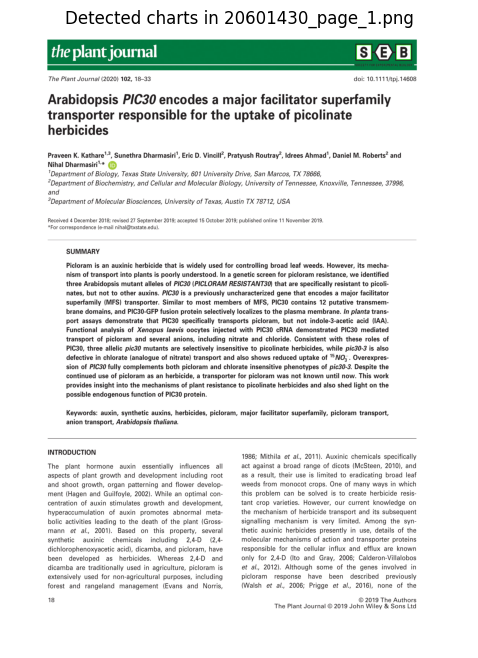

No charts detected in 20601430_page_2.png, skipping.


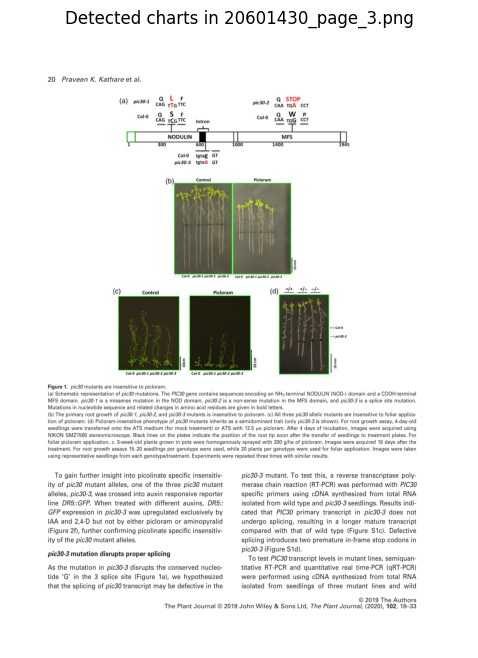

No charts detected in 20601430_page_4.png, skipping.
No charts detected in 20601430_page_5.png, skipping.


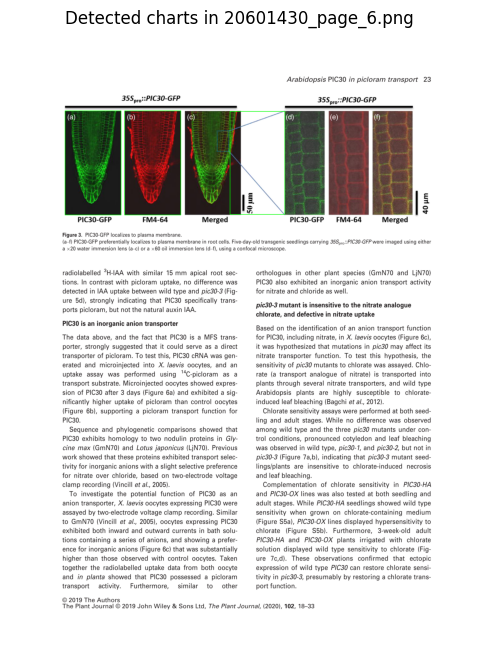

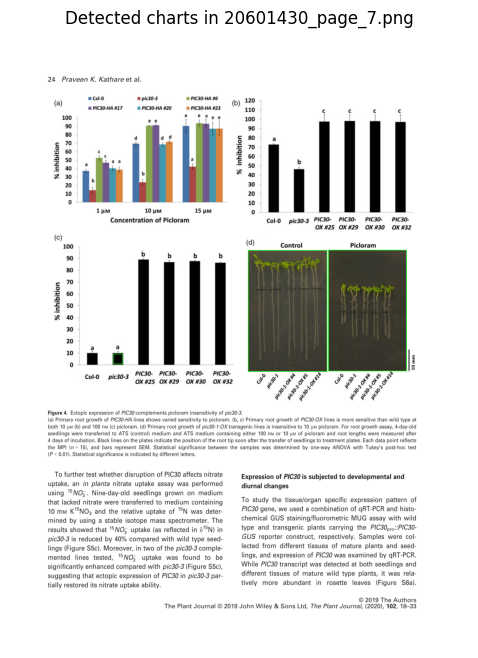

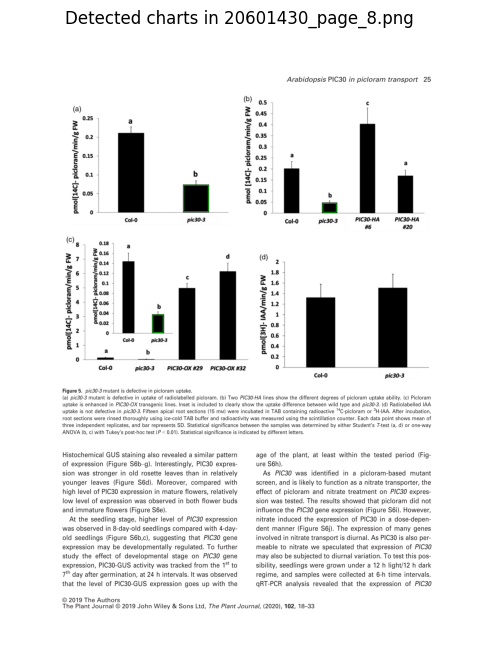

No charts detected in 20601430_page_9.png, skipping.


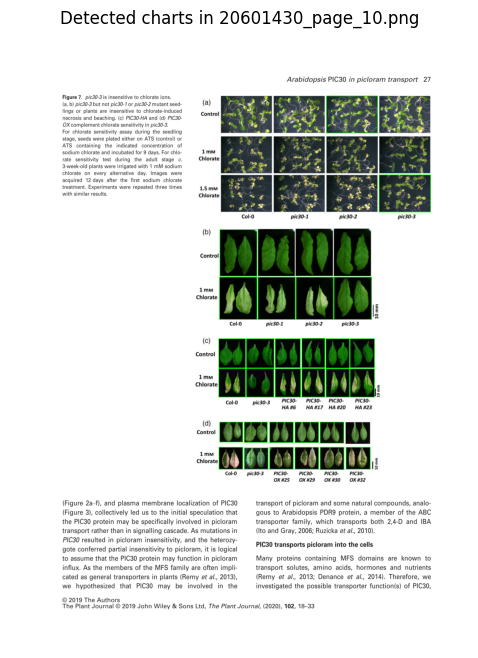

No charts detected in 20601430_page_11.png, skipping.
No charts detected in 20601430_page_12.png, skipping.
No charts detected in 20601430_page_13.png, skipping.
No charts detected in 20601430_page_14.png, skipping.
No charts detected in 20601430_page_15.png, skipping.


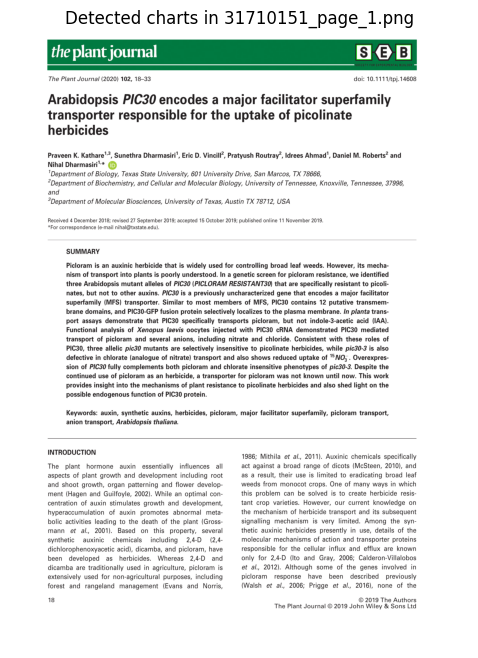

No charts detected in 31710151_page_2.png, skipping.


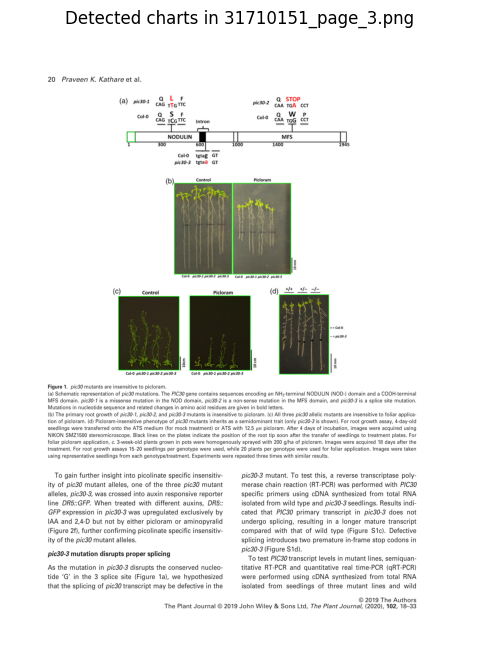

No charts detected in 31710151_page_4.png, skipping.
No charts detected in 31710151_page_5.png, skipping.


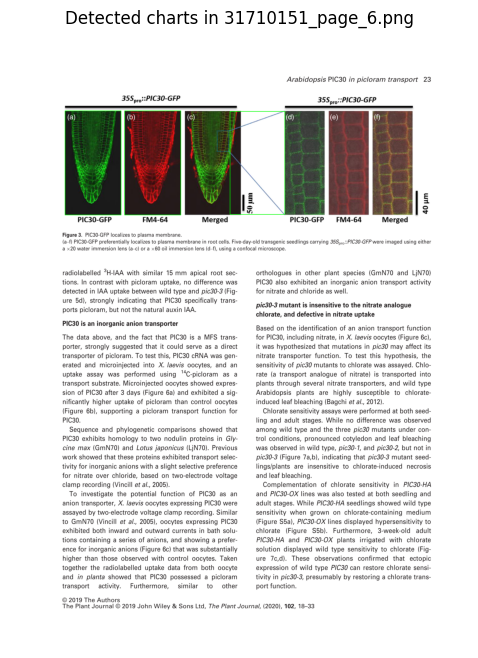

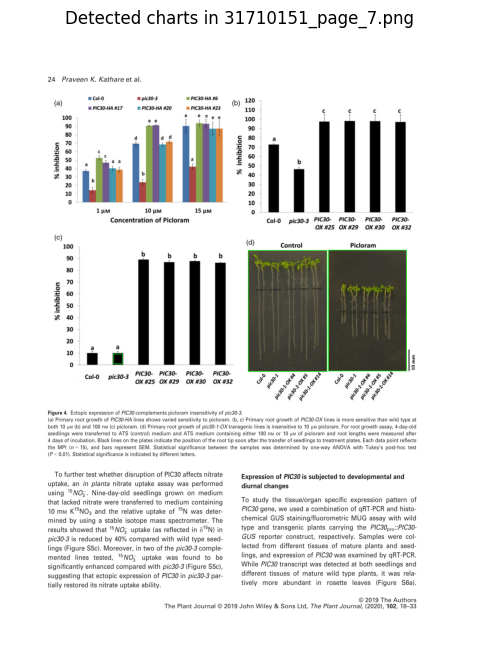

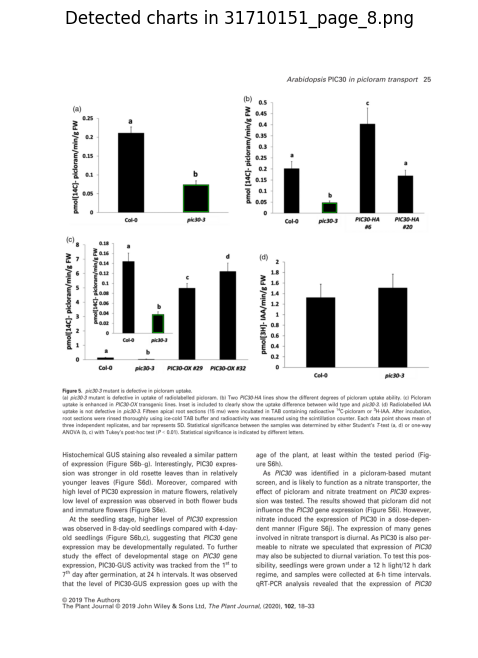

No charts detected in 31710151_page_9.png, skipping.


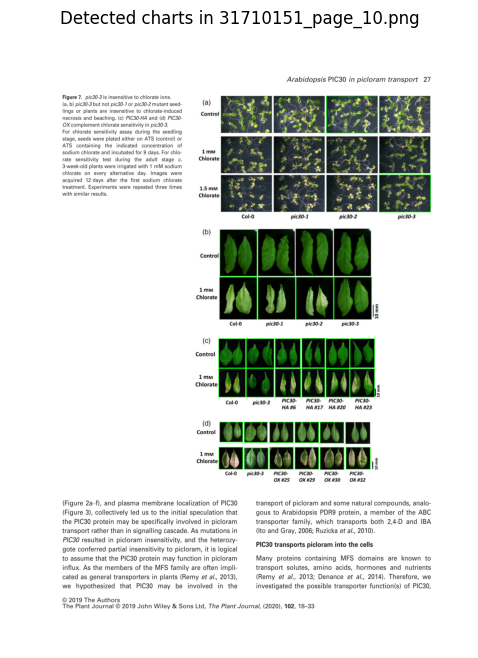

No charts detected in 31710151_page_11.png, skipping.
No charts detected in 31710151_page_12.png, skipping.
No charts detected in 31710151_page_13.png, skipping.
No charts detected in 31710151_page_14.png, skipping.
No charts detected in 31710151_page_15.png, skipping.
No charts detected in 31710151_page_16.png, skipping.


In [82]:
for img_path in Path(output_folder).glob("*.png"):
    #reads image file and loads it into OpenCV compatible format (multidimentional array)
    img = cv2.imread(str(img_path))
    #converts color image to grayscale (reducing to one intensity channel (brightness))
    #this simplifies processing
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #converts grayscale image to binary (black&white) based on calculated threshold
    #gray_img: image
    #255: max val assigned to pixels (that meet threshold condition)
    #cv2.ADAPTIVE_THRESH_GAUSSIAN_C: sets the method to gaussian, each pixel threshold
    #is computed based on nearby pixels
    #cv2.THRESH_BINARY_INV: inverts binary image, setting pizels to below
    #threshold 255 (white) and above 0 (black)
    # 11 + 2: 11 is the block size or area of neighboring pixels
    # 2 is a constant subtracted from mean to fine-tune the threshold
    thresh_img = cv2.adaptiveThreshold(
        gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    #canny edge detection
    #cv2.Canny: detects edges in binary image using canny algorithm
    #100 + 200: the lower and upper thresholds for edge detection
    #pixels with gradients about 200 are edges and below 100 is ignored
    edge_img = cv2.Canny(thresh_img, 100, 200)

    #finding contours
    #cv2.findContours: finds contours (outlines of shapes) in image
    #cv2.RETR_EXTERNAL: retrieves only outer contours (we ignored nested)
    #cv2.CHAIN_APPROX_SIMPLE: simplifies the contours to reduce points and storage
    #cnts: stores list of detected contours as array of points
    cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #track detections and initialize counter for the cropped images
    found_chart = False
    chart_count = 0

    #filter contours (using our five techniques)
    #loops over each detected contour in cnts
    #cv2.contourArea(c): calculates the area of contour c.
    #cv2.arcLength(c, True): calculates perimeter of contour c (True = contour is closed)
    for c in cnts:
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)

        #1: min area threshold (might can adjust based on image size)
        if area < 2000:
            continue

        #bounding boxes
        #cv2.boundingRect(c): creates bounding rect. for contour c
        #returns the top-left corner coordinates (x,y) and width and height
        #(for further checks)
        x, y, w, h = cv2.boundingRect(c)

        #2: aspect ratio check (non-rectangular objects)
        #filters out contours that are too narrow or tall
        aspect_ratio = w / float(h)
        if not (0.5 < aspect_ratio < 2.5):  #can be adjust based on chart dimensions
            continue

        #3: circularity check (filter circular/small shapes)
        #circularity: 4 * (pi) * area/(perimeter^2)
        #circularity close to 1 is circular
        circularity = 4 * 3.14159 * (area / (perimeter * perimeter)) if perimeter != 0 else 0
        if circularity > 0.8:
            continue

        #4: density (filter thin or sparse contours)
        #density: area / (w * h) where lower density is thin or sparse
        density = area / (w * h)
        if density < 0.4:
            continue

        #5: shape (convex hull comparison)
        #cv2.convexHull(c): calculates convex hull of contour c,
        #this is the smaller convex shape that encloses it
        #solidity: area / hull_area where lower values are irregular
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area != 0 else 0
        if solidity < 0.7:
            continue

        #if all checks are passed
        found_chart = True

        #cv2.rectangle() draws a green rect around chart area
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        #crop region and save
        #extracts chart region using bounding box coords (x,y,w,h)
        cropped_img = img[y:y+h, x:x+w]
        crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
        cv2.imwrite(str(crop_path), cropped_img)
        chart_count += 1

    #save and display (just to visualize without going into folder)
    if found_chart:
        anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
        cv2.imwrite(str(anno_path), img)

        #display
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected charts in {img_path.name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No charts detected in {img_path.name}, skipping.")


## Step 4 : Use ChartOCR to extract data

Steps I had to take to initialize ChartOCR:

Clone GitHub Repository

In [93]:
!rm -rf ChartOCR
!git clone https://github.com/zmykevin/ChartOCR.git
%cd ChartOCR

Cloning into 'ChartOCR'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 300 (delta 45), reused 30 (delta 30), pack-reused 233 (from 1)
Receiving objects: 100% (300/300), 4.77 MiB | 9.99 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/ChartOCR/ChartOCR


Initialize and setup miniconda

In [103]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
!bash miniconda.sh -b -p /usr/local -u

--2024-11-16 23:35:41--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148337011 (141M) [application/octet-stream]
Saving to: ‘miniconda.sh’

miniconda.sh        100%[===================>] 141.46M   134MB/s    in 1.1s    

2024-11-16 23:35:42 (134 MB/s) - ‘miniconda.sh’ saved [148337011/148337011]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of pack

WARNING:
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local

In [105]:
conda --version

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [100]:
!unset PYTHONPATH
!source activate ChartOCR


EnvironmentNameNotFound: Could not find conda environment: ChartOCR
You can list all discoverable environments with `conda info --envs`.




In [101]:
conda create --name ChartOCR --file DeepRule.txt

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

Install ChartOCR

## Step 5 : Format and output data

## Step 6 : Format and output data